<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=5db9e5457468fb78b21d6a11651142c0fbcd172eda653e6f2346bd1db86a24e0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=665260f0e1aa03b7f3f9d346f1f7117fe709353233913e470d6486e8a760773a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:01<00:00, 118MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [3]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [4]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 100
    batch_size = 16
    learning_rate = 2e-4
    momentum = 0.9
    weight_decay = 1.5e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [5]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [6]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [7]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [ ]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [ ]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=5)
        self.bottleneck2 = Bottleneck(512, num_layers=5)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##5.7 Attention-Res-YNet

In [8]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
# Encoder with ResNet34 backbone
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)   # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)  # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)   # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)   # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)   # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)   # [B, 512, H/32, W/32]
        return x5, [x0, x1, x2, x3, x4]
# Bottleneck with CBAM
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
# Decoder with CBAM
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output
# Complete YNet with ResNet34 and CBAM
class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 188MB/s]


#6. Training and testing

In [14]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 40:
        return 0.25
    #elif 50 <= epoch < 70:
        #return 0.2
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)

from segmentation_models_pytorch.losses import FocalLoss

class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0, weight_focal=1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = weight_dice
        self.bce_weight = weight_bce
        self.focal_weight = weight_focal
        self.focal_loss = FocalLoss(mode='binary')

    def forward(self, outputs, targets):
        # Ensure outputs and targets have the same shape
        assert outputs.shape == targets.shape, f"Shape mismatch: outputs {outputs.shape}, targets {targets.shape}"

        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        focal_loss = self.focal_loss(outputs, targets)

        total_loss = (self.bce_weight * bce_loss +
                      self.dice_weight * dice_loss +
                      self.focal_weight * focal_loss)
        return total_loss

# Instantiate the criterion
criterion = CombinedLoss(weight_bce=0.2, weight_dice=1.0, weight_focal=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [15]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/100 - Training: 100%|██████████| 18/18 [00:05<00:00,  3.29it/s]


Epoch 1/100, Training Loss: 0.8832


Epoch 1/100 - Validation: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Epoch 1/100, Validation Loss: 0.9198
Precision: 0.0000, Recall: 0.0000, Accuracy: 0.6799
IoU: 0.0000, F1 Score: 0.0000, Dice Coefficient: 0.0000
Pixel Error: 0.3201, Rand Error: 1.0000


Epoch 2/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 2/100, Training Loss: 0.8469


Epoch 2/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 2/100, Validation Loss: 0.8863
Precision: 0.7239, Recall: 0.0106, Accuracy: 0.6820
IoU: 0.0129, F1 Score: 0.0209, Dice Coefficient: 0.0251
Pixel Error: 0.3180, Rand Error: 0.9902


Epoch 3/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 3/100, Training Loss: 0.6680


Epoch 3/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 3/100, Validation Loss: 0.5461
Precision: 0.8429, Recall: 0.9531, Accuracy: 0.9281
IoU: 0.8094, F1 Score: 0.8946, Dice Coefficient: 0.8936
Pixel Error: 0.0719, Rand Error: 0.2689


Epoch 4/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 4/100, Training Loss: 0.5649


Epoch 4/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 4/100, Validation Loss: 0.5865
Precision: 0.9571, Recall: 0.8743, Accuracy: 0.9472
IoU: 0.8415, F1 Score: 0.9138, Dice Coefficient: 0.9134
Pixel Error: 0.0528, Rand Error: 0.2056


Epoch 5/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 5/100, Training Loss: 0.5190


Epoch 5/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 5/100, Validation Loss: 0.5507
Precision: 0.9689, Recall: 0.8758, Accuracy: 0.9512
IoU: 0.8454, F1 Score: 0.9200, Dice Coefficient: 0.9156
Pixel Error: 0.0488, Rand Error: 0.1940


Epoch 6/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 6/100, Training Loss: 0.4848


Epoch 6/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 6/100, Validation Loss: 0.5769
Precision: 0.7719, Recall: 0.9762, Accuracy: 0.9000
IoU: 0.7562, F1 Score: 0.8621, Dice Coefficient: 0.8602
Pixel Error: 0.1000, Rand Error: 0.3627


Epoch 7/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 7/100, Training Loss: 0.4626


Epoch 7/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 7/100, Validation Loss: 0.5063
Precision: 0.9006, Recall: 0.9707, Accuracy: 0.9563
IoU: 0.8764, F1 Score: 0.9344, Dice Coefficient: 0.9340
Pixel Error: 0.0437, Rand Error: 0.1700


Epoch 8/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 8/100, Training Loss: 0.4474


Epoch 8/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 8/100, Validation Loss: 0.4478
Precision: 0.9226, Recall: 0.9655, Accuracy: 0.9630
IoU: 0.8867, F1 Score: 0.9435, Dice Coefficient: 0.9391
Pixel Error: 0.0370, Rand Error: 0.1491


Epoch 9/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 9/100, Training Loss: 0.4277


Epoch 9/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 9/100, Validation Loss: 0.4639
Precision: 0.9605, Recall: 0.9398, Accuracy: 0.9683
IoU: 0.9018, F1 Score: 0.9500, Dice Coefficient: 0.9480
Pixel Error: 0.0317, Rand Error: 0.1275


Epoch 10/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 10/100, Training Loss: 0.4104


Epoch 10/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 10/100, Validation Loss: 0.4835
Precision: 0.9422, Recall: 0.9610, Accuracy: 0.9686
IoU: 0.9081, F1 Score: 0.9515, Dice Coefficient: 0.9516
Pixel Error: 0.0314, Rand Error: 0.1243


Epoch 11/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 11/100, Training Loss: 0.3888


Epoch 11/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 11/100, Validation Loss: 0.4423
Precision: 0.9657, Recall: 0.9272, Accuracy: 0.9662
IoU: 0.8990, F1 Score: 0.9461, Dice Coefficient: 0.9466
Pixel Error: 0.0338, Rand Error: 0.1336


Epoch 12/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 12/100, Training Loss: 0.3633


Epoch 12/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 12/100, Validation Loss: 0.4372
Precision: 0.9541, Recall: 0.9553, Accuracy: 0.9710
IoU: 0.9140, F1 Score: 0.9547, Dice Coefficient: 0.9549
Pixel Error: 0.0290, Rand Error: 0.1151


Epoch 13/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 13/100, Training Loss: 0.3599


Epoch 13/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 13/100, Validation Loss: 0.3615
Precision: 0.9262, Recall: 0.9791, Accuracy: 0.9683
IoU: 0.9063, F1 Score: 0.9519, Dice Coefficient: 0.9506
Pixel Error: 0.0317, Rand Error: 0.1259


Epoch 14/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 14/100, Training Loss: 0.3554


Epoch 14/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 14/100, Validation Loss: 0.4193
Precision: 0.8926, Recall: 0.9715, Accuracy: 0.9534
IoU: 0.8691, F1 Score: 0.9303, Dice Coefficient: 0.9298
Pixel Error: 0.0466, Rand Error: 0.1802


Epoch 15/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 15/100, Training Loss: 0.3309


Epoch 15/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 15/100, Validation Loss: 0.3849
Precision: 0.9193, Recall: 0.9638, Accuracy: 0.9613
IoU: 0.8883, F1 Score: 0.9410, Dice Coefficient: 0.9407
Pixel Error: 0.0387, Rand Error: 0.1517


Epoch 16/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 16/100, Training Loss: 0.3130


Epoch 16/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 16/100, Validation Loss: 0.3502
Precision: 0.9666, Recall: 0.9353, Accuracy: 0.9690
IoU: 0.9047, F1 Score: 0.9507, Dice Coefficient: 0.9497
Pixel Error: 0.0310, Rand Error: 0.1243


Epoch 17/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 17/100, Training Loss: 0.2857


Epoch 17/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 17/100, Validation Loss: 0.3249
Precision: 0.9255, Recall: 0.9741, Accuracy: 0.9666
IoU: 0.9020, F1 Score: 0.9492, Dice Coefficient: 0.9482
Pixel Error: 0.0334, Rand Error: 0.1318


Epoch 18/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 18/100, Training Loss: 0.2642


Epoch 18/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 18/100, Validation Loss: 0.3190
Precision: 0.9597, Recall: 0.9550, Accuracy: 0.9727
IoU: 0.9193, F1 Score: 0.9573, Dice Coefficient: 0.9578
Pixel Error: 0.0273, Rand Error: 0.1080


Epoch 19/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 19/100, Training Loss: 0.2488


Epoch 19/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 19/100, Validation Loss: 0.2965
Precision: 0.9468, Recall: 0.9772, Accuracy: 0.9751
IoU: 0.9249, F1 Score: 0.9618, Dice Coefficient: 0.9609
Pixel Error: 0.0249, Rand Error: 0.0996


Epoch 20/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 20/100, Training Loss: 0.2282


Epoch 20/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 20/100, Validation Loss: 0.2719
Precision: 0.9619, Recall: 0.9585, Accuracy: 0.9746
IoU: 0.9210, F1 Score: 0.9602, Dice Coefficient: 0.9587
Pixel Error: 0.0254, Rand Error: 0.1023


Epoch 21/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 21/100, Training Loss: 0.2200


Epoch 21/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 21/100, Validation Loss: 0.2534
Precision: 0.9643, Recall: 0.9602, Accuracy: 0.9759
IoU: 0.9263, F1 Score: 0.9622, Dice Coefficient: 0.9616
Pixel Error: 0.0241, Rand Error: 0.0967


Epoch 22/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 22/100, Training Loss: 0.2133


Epoch 22/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 22/100, Validation Loss: 0.2763
Precision: 0.9568, Recall: 0.9696, Accuracy: 0.9762
IoU: 0.9272, F1 Score: 0.9631, Dice Coefficient: 0.9621
Pixel Error: 0.0238, Rand Error: 0.0954


Epoch 23/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 23/100, Training Loss: 0.2040


Epoch 23/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 23/100, Validation Loss: 0.2600
Precision: 0.9544, Recall: 0.9719, Accuracy: 0.9761
IoU: 0.9279, F1 Score: 0.9630, Dice Coefficient: 0.9625
Pixel Error: 0.0239, Rand Error: 0.0955


Epoch 24/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 24/100, Training Loss: 0.1921


Epoch 24/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 24/100, Validation Loss: 0.2529
Precision: 0.9548, Recall: 0.9721, Accuracy: 0.9763
IoU: 0.9287, F1 Score: 0.9634, Dice Coefficient: 0.9629
Pixel Error: 0.0237, Rand Error: 0.0945


Epoch 25/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 25/100, Training Loss: 0.1921


Epoch 25/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 25/100, Validation Loss: 0.2486
Precision: 0.9625, Recall: 0.9637, Accuracy: 0.9764
IoU: 0.9280, F1 Score: 0.9631, Dice Coefficient: 0.9625
Pixel Error: 0.0236, Rand Error: 0.0946


Epoch 26/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 26/100, Training Loss: 0.1840


Epoch 26/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 26/100, Validation Loss: 0.2348
Precision: 0.9568, Recall: 0.9732, Accuracy: 0.9773
IoU: 0.9319, F1 Score: 0.9649, Dice Coefficient: 0.9647
Pixel Error: 0.0227, Rand Error: 0.0905


Epoch 27/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 27/100, Training Loss: 0.1801


Epoch 27/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 27/100, Validation Loss: 0.2406
Precision: 0.9593, Recall: 0.9695, Accuracy: 0.9771
IoU: 0.9305, F1 Score: 0.9644, Dice Coefficient: 0.9639
Pixel Error: 0.0229, Rand Error: 0.0918


Epoch 28/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 28/100, Training Loss: 0.1761


Epoch 28/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 28/100, Validation Loss: 0.2437
Precision: 0.9541, Recall: 0.9721, Accuracy: 0.9761
IoU: 0.9285, F1 Score: 0.9630, Dice Coefficient: 0.9628
Pixel Error: 0.0239, Rand Error: 0.0953


Epoch 29/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 29/100, Training Loss: 0.1668


Epoch 29/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 29/100, Validation Loss: 0.2357
Precision: 0.9629, Recall: 0.9651, Accuracy: 0.9769
IoU: 0.9303, F1 Score: 0.9640, Dice Coefficient: 0.9637
Pixel Error: 0.0231, Rand Error: 0.0923


Epoch 30/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 30/100, Training Loss: 0.1625


Epoch 30/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 30/100, Validation Loss: 0.2196
Precision: 0.9651, Recall: 0.9611, Accuracy: 0.9764
IoU: 0.9283, F1 Score: 0.9631, Dice Coefficient: 0.9626
Pixel Error: 0.0236, Rand Error: 0.0943


Epoch 31/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


Epoch 31/100, Training Loss: 0.1552


Epoch 31/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 31/100, Validation Loss: 0.2125
Precision: 0.9633, Recall: 0.9668, Accuracy: 0.9776
IoU: 0.9324, F1 Score: 0.9651, Dice Coefficient: 0.9648
Pixel Error: 0.0224, Rand Error: 0.0896


Epoch 32/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 32/100, Training Loss: 0.1521


Epoch 32/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 32/100, Validation Loss: 0.2069
Precision: 0.9605, Recall: 0.9698, Accuracy: 0.9776
IoU: 0.9324, F1 Score: 0.9651, Dice Coefficient: 0.9648
Pixel Error: 0.0224, Rand Error: 0.0896


Epoch 33/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 33/100, Training Loss: 0.1507


Epoch 33/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 33/100, Validation Loss: 0.2063
Precision: 0.9600, Recall: 0.9703, Accuracy: 0.9776
IoU: 0.9326, F1 Score: 0.9651, Dice Coefficient: 0.9650
Pixel Error: 0.0224, Rand Error: 0.0895


Epoch 34/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 34/100, Training Loss: 0.1521


Epoch 34/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 34/100, Validation Loss: 0.2078
Precision: 0.9573, Recall: 0.9727, Accuracy: 0.9774
IoU: 0.9321, F1 Score: 0.9649, Dice Coefficient: 0.9647
Pixel Error: 0.0226, Rand Error: 0.0904


Epoch 35/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 35/100, Training Loss: 0.1440


Epoch 35/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 35/100, Validation Loss: 0.2025
Precision: 0.9612, Recall: 0.9686, Accuracy: 0.9774
IoU: 0.9318, F1 Score: 0.9649, Dice Coefficient: 0.9645
Pixel Error: 0.0226, Rand Error: 0.0903


Epoch 36/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 36/100, Training Loss: 0.1424


Epoch 36/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 36/100, Validation Loss: 0.1912
Precision: 0.9619, Recall: 0.9689, Accuracy: 0.9777
IoU: 0.9326, F1 Score: 0.9654, Dice Coefficient: 0.9650
Pixel Error: 0.0223, Rand Error: 0.0891


Epoch 37/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 37/100, Training Loss: 0.1442


Epoch 37/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 37/100, Validation Loss: 0.2039
Precision: 0.9562, Recall: 0.9741, Accuracy: 0.9774
IoU: 0.9327, F1 Score: 0.9651, Dice Coefficient: 0.9650
Pixel Error: 0.0226, Rand Error: 0.0899


Epoch 38/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 38/100, Training Loss: 0.1361


Epoch 38/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 38/100, Validation Loss: 0.1946
Precision: 0.9611, Recall: 0.9718, Accuracy: 0.9784
IoU: 0.9350, F1 Score: 0.9664, Dice Coefficient: 0.9663
Pixel Error: 0.0216, Rand Error: 0.0864


Epoch 39/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


Epoch 39/100, Training Loss: 0.1406


Epoch 39/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 39/100, Validation Loss: 0.1910
Precision: 0.9615, Recall: 0.9714, Accuracy: 0.9784
IoU: 0.9348, F1 Score: 0.9664, Dice Coefficient: 0.9662
Pixel Error: 0.0216, Rand Error: 0.0865


Epoch 40/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 40/100, Training Loss: 0.1302


Epoch 40/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 40/100, Validation Loss: 0.1999
Precision: 0.9538, Recall: 0.9763, Accuracy: 0.9773
IoU: 0.9316, F1 Score: 0.9649, Dice Coefficient: 0.9644
Pixel Error: 0.0227, Rand Error: 0.0909


Epoch 41/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 41/100, Training Loss: 0.1280


Epoch 41/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 41/100, Validation Loss: 0.1832
Precision: 0.9600, Recall: 0.9735, Accuracy: 0.9785
IoU: 0.9350, F1 Score: 0.9667, Dice Coefficient: 0.9663
Pixel Error: 0.0215, Rand Error: 0.0860


Epoch 42/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 42/100, Training Loss: 0.1289


Epoch 42/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 42/100, Validation Loss: 0.1861
Precision: 0.9591, Recall: 0.9740, Accuracy: 0.9784
IoU: 0.9346, F1 Score: 0.9665, Dice Coefficient: 0.9660
Pixel Error: 0.0216, Rand Error: 0.0866


Epoch 43/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


Epoch 43/100, Training Loss: 0.1265


Epoch 43/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 43/100, Validation Loss: 0.1843
Precision: 0.9613, Recall: 0.9713, Accuracy: 0.9783
IoU: 0.9345, F1 Score: 0.9663, Dice Coefficient: 0.9660
Pixel Error: 0.0217, Rand Error: 0.0869


Epoch 44/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 44/100, Training Loss: 0.1325


Epoch 44/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 44/100, Validation Loss: 0.1829
Precision: 0.9610, Recall: 0.9717, Accuracy: 0.9783
IoU: 0.9348, F1 Score: 0.9663, Dice Coefficient: 0.9661
Pixel Error: 0.0217, Rand Error: 0.0867


Epoch 45/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 45/100, Training Loss: 0.1305


Epoch 45/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 45/100, Validation Loss: 0.1837
Precision: 0.9608, Recall: 0.9721, Accuracy: 0.9784
IoU: 0.9349, F1 Score: 0.9664, Dice Coefficient: 0.9662
Pixel Error: 0.0216, Rand Error: 0.0865


Epoch 46/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 46/100, Training Loss: 0.1257


Epoch 46/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 46/100, Validation Loss: 0.1816
Precision: 0.9623, Recall: 0.9698, Accuracy: 0.9782
IoU: 0.9342, F1 Score: 0.9660, Dice Coefficient: 0.9658
Pixel Error: 0.0218, Rand Error: 0.0873


Epoch 47/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 47/100, Training Loss: 0.1253


Epoch 47/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 47/100, Validation Loss: 0.1838
Precision: 0.9599, Recall: 0.9716, Accuracy: 0.9779
IoU: 0.9336, F1 Score: 0.9657, Dice Coefficient: 0.9655
Pixel Error: 0.0221, Rand Error: 0.0883


Epoch 48/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 48/100, Training Loss: 0.1299


Epoch 48/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 48/100, Validation Loss: 0.1837
Precision: 0.9606, Recall: 0.9704, Accuracy: 0.9778
IoU: 0.9334, F1 Score: 0.9655, Dice Coefficient: 0.9654
Pixel Error: 0.0222, Rand Error: 0.0887


Epoch 49/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 49/100, Training Loss: 0.1251


Epoch 49/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 49/100, Validation Loss: 0.1803
Precision: 0.9581, Recall: 0.9733, Accuracy: 0.9778
IoU: 0.9338, F1 Score: 0.9657, Dice Coefficient: 0.9656
Pixel Error: 0.0222, Rand Error: 0.0884


Epoch 50/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 50/100, Training Loss: 0.1248


Epoch 50/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 50/100, Validation Loss: 0.1829
Precision: 0.9582, Recall: 0.9733, Accuracy: 0.9779
IoU: 0.9336, F1 Score: 0.9657, Dice Coefficient: 0.9655
Pixel Error: 0.0221, Rand Error: 0.0884


Epoch 51/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 51/100, Training Loss: 0.1203


Epoch 51/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 51/100, Validation Loss: 0.1793
Precision: 0.9610, Recall: 0.9707, Accuracy: 0.9780
IoU: 0.9339, F1 Score: 0.9658, Dice Coefficient: 0.9657
Pixel Error: 0.0220, Rand Error: 0.0878


Epoch 52/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 52/100, Training Loss: 0.1245


Epoch 52/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 52/100, Validation Loss: 0.1822
Precision: 0.9598, Recall: 0.9719, Accuracy: 0.9780
IoU: 0.9340, F1 Score: 0.9658, Dice Coefficient: 0.9657
Pixel Error: 0.0220, Rand Error: 0.0879


Epoch 53/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 53/100, Training Loss: 0.1260


Epoch 53/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 53/100, Validation Loss: 0.1826
Precision: 0.9635, Recall: 0.9686, Accuracy: 0.9782
IoU: 0.9346, F1 Score: 0.9660, Dice Coefficient: 0.9661
Pixel Error: 0.0218, Rand Error: 0.0870


Epoch 54/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 54/100, Training Loss: 0.1198


Epoch 54/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 54/100, Validation Loss: 0.1765
Precision: 0.9591, Recall: 0.9728, Accuracy: 0.9780
IoU: 0.9340, F1 Score: 0.9659, Dice Coefficient: 0.9657
Pixel Error: 0.0220, Rand Error: 0.0879


Epoch 55/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 55/100, Training Loss: 0.1178


Epoch 55/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 55/100, Validation Loss: 0.1796
Precision: 0.9570, Recall: 0.9744, Accuracy: 0.9778
IoU: 0.9337, F1 Score: 0.9656, Dice Coefficient: 0.9655
Pixel Error: 0.0222, Rand Error: 0.0885


Epoch 56/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 56/100, Training Loss: 0.1150


Epoch 56/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 56/100, Validation Loss: 0.1799
Precision: 0.9571, Recall: 0.9743, Accuracy: 0.9778
IoU: 0.9335, F1 Score: 0.9656, Dice Coefficient: 0.9655
Pixel Error: 0.0222, Rand Error: 0.0887


Epoch 57/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 57/100, Training Loss: 0.1180


Epoch 57/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 57/100, Validation Loss: 0.1799
Precision: 0.9604, Recall: 0.9706, Accuracy: 0.9778
IoU: 0.9333, F1 Score: 0.9655, Dice Coefficient: 0.9653
Pixel Error: 0.0222, Rand Error: 0.0887


Epoch 58/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 58/100, Training Loss: 0.1149


Epoch 58/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 58/100, Validation Loss: 0.1744
Precision: 0.9614, Recall: 0.9703, Accuracy: 0.9780
IoU: 0.9343, F1 Score: 0.9658, Dice Coefficient: 0.9659
Pixel Error: 0.0220, Rand Error: 0.0876


Epoch 59/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


Epoch 59/100, Training Loss: 0.1199


Epoch 59/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 59/100, Validation Loss: 0.1747
Precision: 0.9635, Recall: 0.9682, Accuracy: 0.9781
IoU: 0.9343, F1 Score: 0.9658, Dice Coefficient: 0.9659
Pixel Error: 0.0219, Rand Error: 0.0875


Epoch 60/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 60/100, Training Loss: 0.1185


Epoch 60/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 60/100, Validation Loss: 0.1805
Precision: 0.9626, Recall: 0.9702, Accuracy: 0.9784
IoU: 0.9352, F1 Score: 0.9664, Dice Coefficient: 0.9664
Pixel Error: 0.0216, Rand Error: 0.0862


Epoch 61/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 61/100, Training Loss: 0.1220


Epoch 61/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 61/100, Validation Loss: 0.1730
Precision: 0.9607, Recall: 0.9706, Accuracy: 0.9779
IoU: 0.9339, F1 Score: 0.9656, Dice Coefficient: 0.9657
Pixel Error: 0.0221, Rand Error: 0.0882


Epoch 62/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 62/100, Training Loss: 0.1127


Epoch 62/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 62/100, Validation Loss: 0.1716
Precision: 0.9625, Recall: 0.9694, Accuracy: 0.9781
IoU: 0.9344, F1 Score: 0.9659, Dice Coefficient: 0.9660
Pixel Error: 0.0219, Rand Error: 0.0874


Epoch 63/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 63/100, Training Loss: 0.1126


Epoch 63/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 63/100, Validation Loss: 0.1761
Precision: 0.9603, Recall: 0.9714, Accuracy: 0.9780
IoU: 0.9341, F1 Score: 0.9658, Dice Coefficient: 0.9658
Pixel Error: 0.0220, Rand Error: 0.0878


Epoch 64/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 64/100, Training Loss: 0.1161


Epoch 64/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 64/100, Validation Loss: 0.1724
Precision: 0.9630, Recall: 0.9694, Accuracy: 0.9783
IoU: 0.9349, F1 Score: 0.9662, Dice Coefficient: 0.9662
Pixel Error: 0.0217, Rand Error: 0.0866


Epoch 65/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 65/100, Training Loss: 0.1144


Epoch 65/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 65/100, Validation Loss: 0.1752
Precision: 0.9650, Recall: 0.9662, Accuracy: 0.9780
IoU: 0.9339, F1 Score: 0.9656, Dice Coefficient: 0.9657
Pixel Error: 0.0220, Rand Error: 0.0879


Epoch 66/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 66/100, Training Loss: 0.1098


Epoch 66/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 66/100, Validation Loss: 0.1702
Precision: 0.9619, Recall: 0.9688, Accuracy: 0.9777
IoU: 0.9335, F1 Score: 0.9653, Dice Coefficient: 0.9654
Pixel Error: 0.0223, Rand Error: 0.0887


Epoch 67/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 67/100, Training Loss: 0.1089


Epoch 67/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 67/100, Validation Loss: 0.1741
Precision: 0.9608, Recall: 0.9702, Accuracy: 0.9778
IoU: 0.9339, F1 Score: 0.9655, Dice Coefficient: 0.9657
Pixel Error: 0.0222, Rand Error: 0.0883


Epoch 68/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 68/100, Training Loss: 0.1047


Epoch 68/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 68/100, Validation Loss: 0.1705
Precision: 0.9595, Recall: 0.9712, Accuracy: 0.9777
IoU: 0.9331, F1 Score: 0.9653, Dice Coefficient: 0.9652
Pixel Error: 0.0223, Rand Error: 0.0891


Epoch 69/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 69/100, Training Loss: 0.1047


Epoch 69/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 69/100, Validation Loss: 0.1696
Precision: 0.9643, Recall: 0.9662, Accuracy: 0.9777
IoU: 0.9332, F1 Score: 0.9653, Dice Coefficient: 0.9653
Pixel Error: 0.0223, Rand Error: 0.0888


Epoch 70/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 70/100, Training Loss: 0.1083


Epoch 70/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 70/100, Validation Loss: 0.1732
Precision: 0.9631, Recall: 0.9687, Accuracy: 0.9781
IoU: 0.9342, F1 Score: 0.9659, Dice Coefficient: 0.9658
Pixel Error: 0.0219, Rand Error: 0.0875


Epoch 71/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


Epoch 71/100, Training Loss: 0.1068


Epoch 71/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 71/100, Validation Loss: 0.1663
Precision: 0.9621, Recall: 0.9696, Accuracy: 0.9780
IoU: 0.9343, F1 Score: 0.9658, Dice Coefficient: 0.9659
Pixel Error: 0.0220, Rand Error: 0.0875


Epoch 72/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 72/100, Training Loss: 0.1082


Epoch 72/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 72/100, Validation Loss: 0.1701
Precision: 0.9615, Recall: 0.9695, Accuracy: 0.9778
IoU: 0.9335, F1 Score: 0.9655, Dice Coefficient: 0.9655
Pixel Error: 0.0222, Rand Error: 0.0885


Epoch 73/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 73/100, Training Loss: 0.1101


Epoch 73/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 73/100, Validation Loss: 0.1719
Precision: 0.9630, Recall: 0.9680, Accuracy: 0.9778
IoU: 0.9335, F1 Score: 0.9655, Dice Coefficient: 0.9655
Pixel Error: 0.0222, Rand Error: 0.0884


Epoch 74/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 74/100, Training Loss: 0.1060


Epoch 74/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 74/100, Validation Loss: 0.1660
Precision: 0.9635, Recall: 0.9672, Accuracy: 0.9778
IoU: 0.9334, F1 Score: 0.9653, Dice Coefficient: 0.9654
Pixel Error: 0.0222, Rand Error: 0.0886


Epoch 75/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 75/100, Training Loss: 0.1010


Epoch 75/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 75/100, Validation Loss: 0.1659
Precision: 0.9600, Recall: 0.9712, Accuracy: 0.9778
IoU: 0.9341, F1 Score: 0.9656, Dice Coefficient: 0.9658
Pixel Error: 0.0222, Rand Error: 0.0883


Epoch 76/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 76/100, Training Loss: 0.1090


Epoch 76/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 76/100, Validation Loss: 0.1694
Precision: 0.9647, Recall: 0.9670, Accuracy: 0.9781
IoU: 0.9343, F1 Score: 0.9658, Dice Coefficient: 0.9659
Pixel Error: 0.0219, Rand Error: 0.0873


Epoch 77/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 77/100, Training Loss: 0.1076


Epoch 77/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 77/100, Validation Loss: 0.1678
Precision: 0.9584, Recall: 0.9723, Accuracy: 0.9776
IoU: 0.9334, F1 Score: 0.9653, Dice Coefficient: 0.9654
Pixel Error: 0.0224, Rand Error: 0.0891


Epoch 78/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 78/100, Training Loss: 0.1051


Epoch 78/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 78/100, Validation Loss: 0.1666
Precision: 0.9613, Recall: 0.9694, Accuracy: 0.9777
IoU: 0.9336, F1 Score: 0.9654, Dice Coefficient: 0.9655
Pixel Error: 0.0223, Rand Error: 0.0886


Epoch 79/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


Epoch 79/100, Training Loss: 0.1019


Epoch 79/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 79/100, Validation Loss: 0.1664
Precision: 0.9613, Recall: 0.9683, Accuracy: 0.9774
IoU: 0.9325, F1 Score: 0.9648, Dice Coefficient: 0.9649
Pixel Error: 0.0226, Rand Error: 0.0900


Epoch 80/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 80/100, Training Loss: 0.1047


Epoch 80/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 80/100, Validation Loss: 0.1737
Precision: 0.9574, Recall: 0.9735, Accuracy: 0.9777
IoU: 0.9333, F1 Score: 0.9654, Dice Coefficient: 0.9654
Pixel Error: 0.0223, Rand Error: 0.0890


Epoch 81/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 81/100, Training Loss: 0.0994


Epoch 81/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 81/100, Validation Loss: 0.1653
Precision: 0.9616, Recall: 0.9693, Accuracy: 0.9778
IoU: 0.9336, F1 Score: 0.9654, Dice Coefficient: 0.9655
Pixel Error: 0.0222, Rand Error: 0.0886


Epoch 82/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


Epoch 82/100, Training Loss: 0.0991


Epoch 82/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 82/100, Validation Loss: 0.1648
Precision: 0.9615, Recall: 0.9691, Accuracy: 0.9777
IoU: 0.9332, F1 Score: 0.9653, Dice Coefficient: 0.9653
Pixel Error: 0.0223, Rand Error: 0.0889


Epoch 83/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 83/100, Training Loss: 0.0962


Epoch 83/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 83/100, Validation Loss: 0.1661
Precision: 0.9617, Recall: 0.9692, Accuracy: 0.9778
IoU: 0.9335, F1 Score: 0.9654, Dice Coefficient: 0.9655
Pixel Error: 0.0222, Rand Error: 0.0886


Epoch 84/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 84/100, Training Loss: 0.1006


Epoch 84/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 84/100, Validation Loss: 0.1663
Precision: 0.9581, Recall: 0.9722, Accuracy: 0.9775
IoU: 0.9328, F1 Score: 0.9651, Dice Coefficient: 0.9651
Pixel Error: 0.0225, Rand Error: 0.0895


Epoch 85/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 85/100, Training Loss: 0.0964


Epoch 85/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 85/100, Validation Loss: 0.1647
Precision: 0.9601, Recall: 0.9706, Accuracy: 0.9777
IoU: 0.9336, F1 Score: 0.9654, Dice Coefficient: 0.9655
Pixel Error: 0.0223, Rand Error: 0.0888


Epoch 86/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


Epoch 86/100, Training Loss: 0.0951


Epoch 86/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 86/100, Validation Loss: 0.1686
Precision: 0.9590, Recall: 0.9710, Accuracy: 0.9774
IoU: 0.9326, F1 Score: 0.9650, Dice Coefficient: 0.9649
Pixel Error: 0.0226, Rand Error: 0.0899


Epoch 87/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


Epoch 87/100, Training Loss: 0.0951


Epoch 87/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 87/100, Validation Loss: 0.1627
Precision: 0.9608, Recall: 0.9686, Accuracy: 0.9773
IoU: 0.9324, F1 Score: 0.9647, Dice Coefficient: 0.9649
Pixel Error: 0.0227, Rand Error: 0.0903


Epoch 88/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 88/100, Training Loss: 0.0931


Epoch 88/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 88/100, Validation Loss: 0.1703
Precision: 0.9593, Recall: 0.9700, Accuracy: 0.9772
IoU: 0.9321, F1 Score: 0.9646, Dice Coefficient: 0.9647
Pixel Error: 0.0228, Rand Error: 0.0907


Epoch 89/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 89/100, Training Loss: 0.0977


Epoch 89/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 89/100, Validation Loss: 0.1656
Precision: 0.9593, Recall: 0.9702, Accuracy: 0.9773
IoU: 0.9325, F1 Score: 0.9647, Dice Coefficient: 0.9649
Pixel Error: 0.0227, Rand Error: 0.0903


Epoch 90/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 90/100, Training Loss: 0.0929


Epoch 90/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 90/100, Validation Loss: 0.1629
Precision: 0.9587, Recall: 0.9697, Accuracy: 0.9769
IoU: 0.9315, F1 Score: 0.9642, Dice Coefficient: 0.9644
Pixel Error: 0.0231, Rand Error: 0.0917


Epoch 91/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 91/100, Training Loss: 0.0920


Epoch 91/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 91/100, Validation Loss: 0.1654
Precision: 0.9595, Recall: 0.9693, Accuracy: 0.9771
IoU: 0.9319, F1 Score: 0.9644, Dice Coefficient: 0.9646
Pixel Error: 0.0229, Rand Error: 0.0911


Epoch 92/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 92/100, Training Loss: 0.0913


Epoch 92/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 92/100, Validation Loss: 0.1631
Precision: 0.9612, Recall: 0.9697, Accuracy: 0.9778
IoU: 0.9337, F1 Score: 0.9654, Dice Coefficient: 0.9656
Pixel Error: 0.0222, Rand Error: 0.0885


Epoch 93/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 93/100, Training Loss: 0.0957


Epoch 93/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 93/100, Validation Loss: 0.1627
Precision: 0.9643, Recall: 0.9619, Accuracy: 0.9764
IoU: 0.9302, F1 Score: 0.9631, Dice Coefficient: 0.9636
Pixel Error: 0.0236, Rand Error: 0.0937


Epoch 94/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


Epoch 94/100, Training Loss: 0.0919


Epoch 94/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 94/100, Validation Loss: 0.1561
Precision: 0.9623, Recall: 0.9679, Accuracy: 0.9776
IoU: 0.9336, F1 Score: 0.9651, Dice Coefficient: 0.9655
Pixel Error: 0.0224, Rand Error: 0.0890


Epoch 95/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 95/100, Training Loss: 0.0885


Epoch 95/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Epoch 95/100, Validation Loss: 0.1608
Precision: 0.9657, Recall: 0.9628, Accuracy: 0.9772
IoU: 0.9320, F1 Score: 0.9643, Dice Coefficient: 0.9647
Pixel Error: 0.0228, Rand Error: 0.0908


Epoch 96/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 96/100, Training Loss: 0.0894


Epoch 96/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 96/100, Validation Loss: 0.1627
Precision: 0.9578, Recall: 0.9708, Accuracy: 0.9770
IoU: 0.9319, F1 Score: 0.9643, Dice Coefficient: 0.9646
Pixel Error: 0.0230, Rand Error: 0.0914


Epoch 97/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 97/100, Training Loss: 0.0893


Epoch 97/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 97/100, Validation Loss: 0.1603
Precision: 0.9644, Recall: 0.9642, Accuracy: 0.9772
IoU: 0.9320, F1 Score: 0.9643, Dice Coefficient: 0.9646
Pixel Error: 0.0228, Rand Error: 0.0908


Epoch 98/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 98/100, Training Loss: 0.0955


Epoch 98/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 98/100, Validation Loss: 0.1625
Precision: 0.9595, Recall: 0.9685, Accuracy: 0.9768
IoU: 0.9314, F1 Score: 0.9640, Dice Coefficient: 0.9643
Pixel Error: 0.0232, Rand Error: 0.0921


Epoch 99/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 99/100, Training Loss: 0.0873


Epoch 99/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 99/100, Validation Loss: 0.1607
Precision: 0.9643, Recall: 0.9634, Accuracy: 0.9769
IoU: 0.9314, F1 Score: 0.9638, Dice Coefficient: 0.9643
Pixel Error: 0.0231, Rand Error: 0.0918


Epoch 100/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 100/100, Training Loss: 0.0883


Epoch 100/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]

Epoch 100/100, Validation Loss: 0.1627
Precision: 0.9635, Recall: 0.9630, Accuracy: 0.9765
IoU: 0.9302, F1 Score: 0.9633, Dice Coefficient: 0.9636
Pixel Error: 0.0235, Rand Error: 0.0933


##6.2 Testing



In [16]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing: 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]

Test Loss: 0.1952
Average Precision: 0.9517
Average Recall: 0.9494
Average Accuracy: 0.9710
Average IoU: 0.9065
Average F1 Score: 0.9503
Average Dice Coefficient: 0.9503
Average Pixel Error: 0.0290
Average Rand Error: 0.0290


In [17]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [18]:
# Save the model
torch.save(model.state_dict(), 'Ynet34-atten_model.pth')

# Load the model
model.load_state_dict(torch.load('Ynet34-atten_model.pth'))
model.eval()

<ipython-input-18-4c799bb9b1d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Ynet34-atten_model.pth'))


YNetResNet34_CBAM(
  (encoder): ResNet34Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

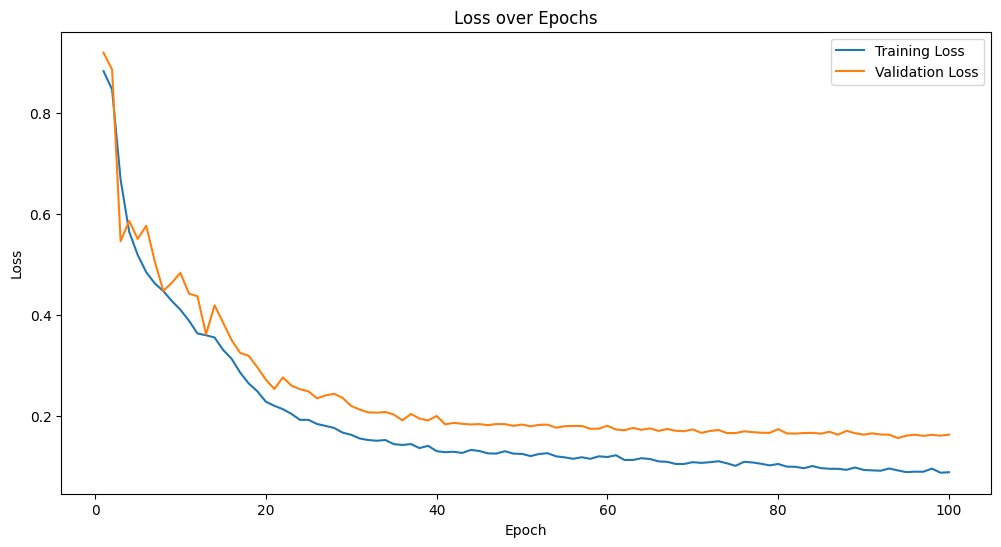

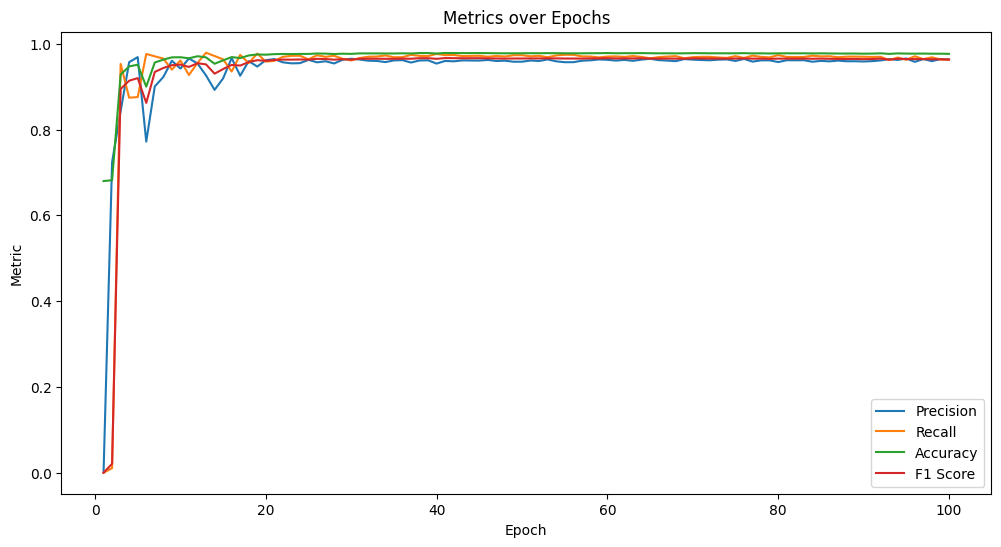

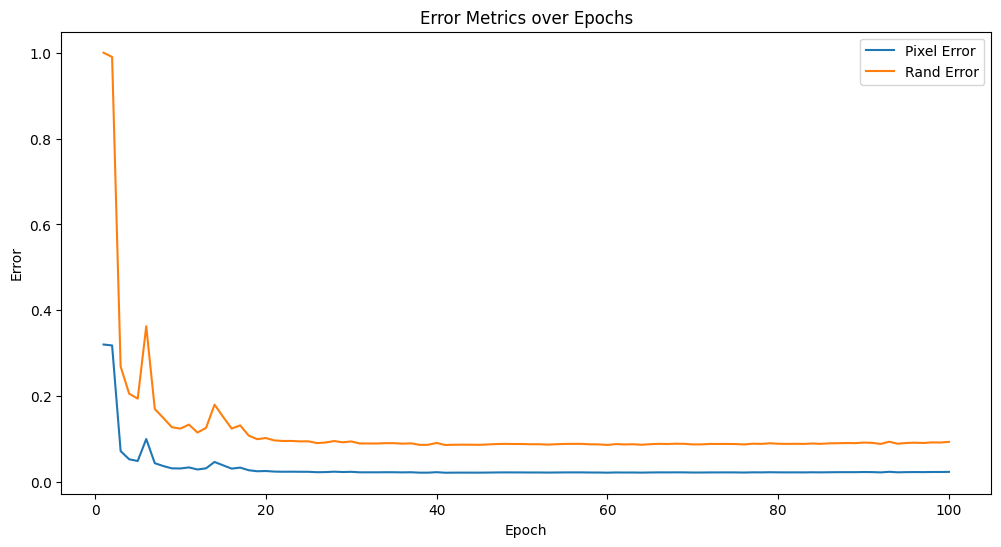

In [19]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



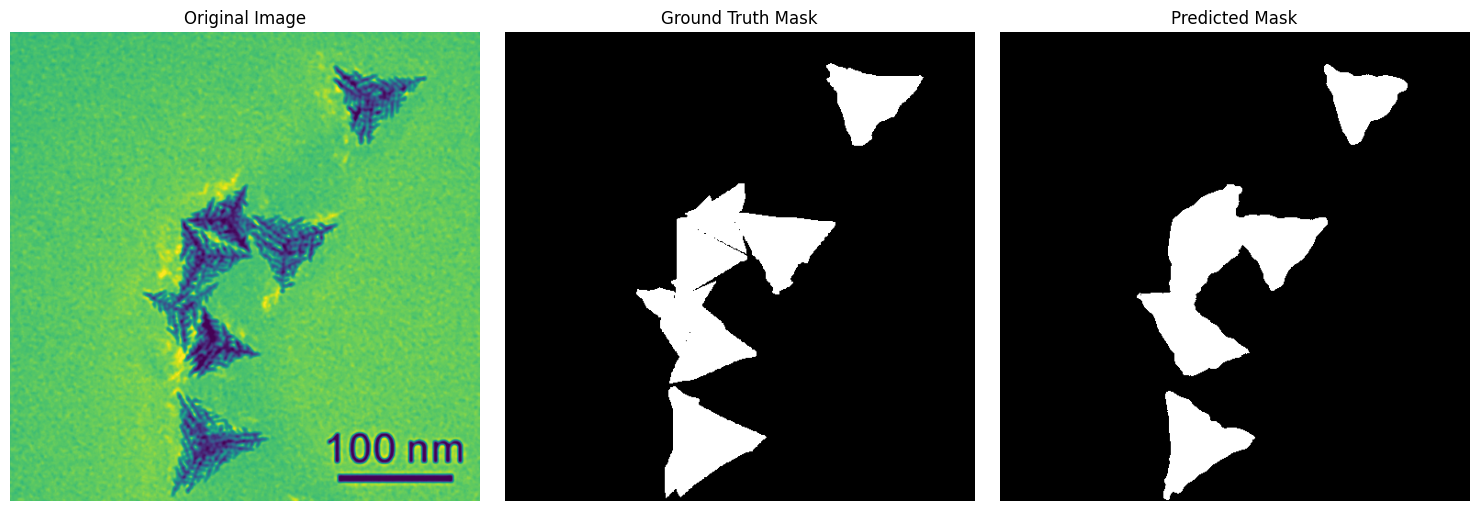

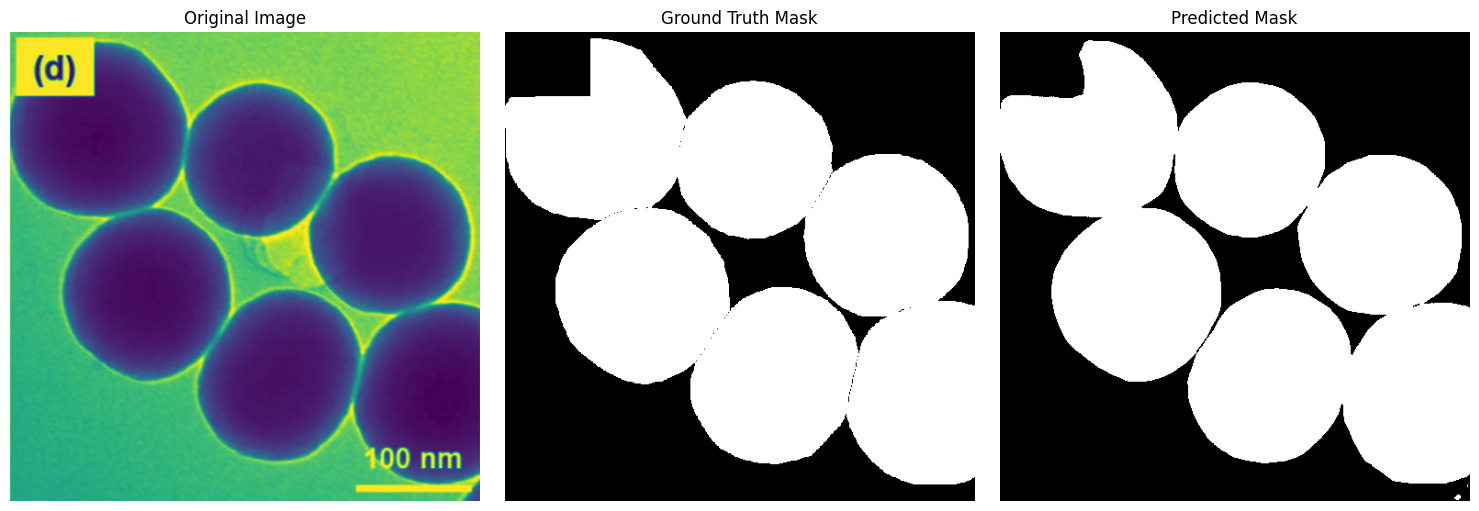

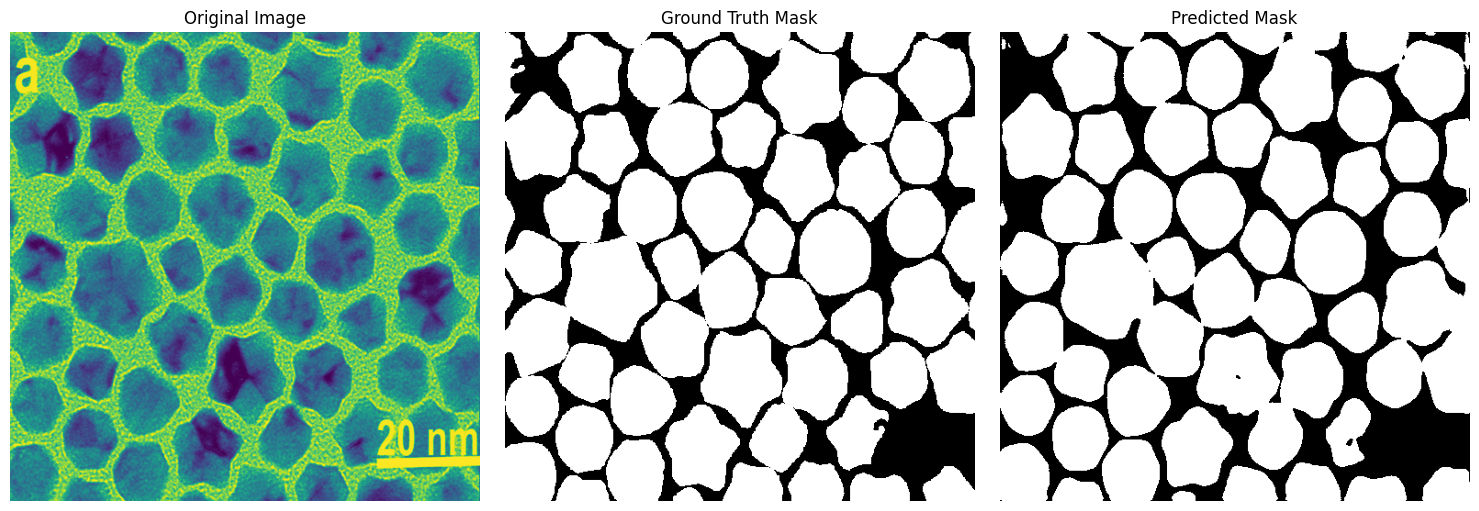

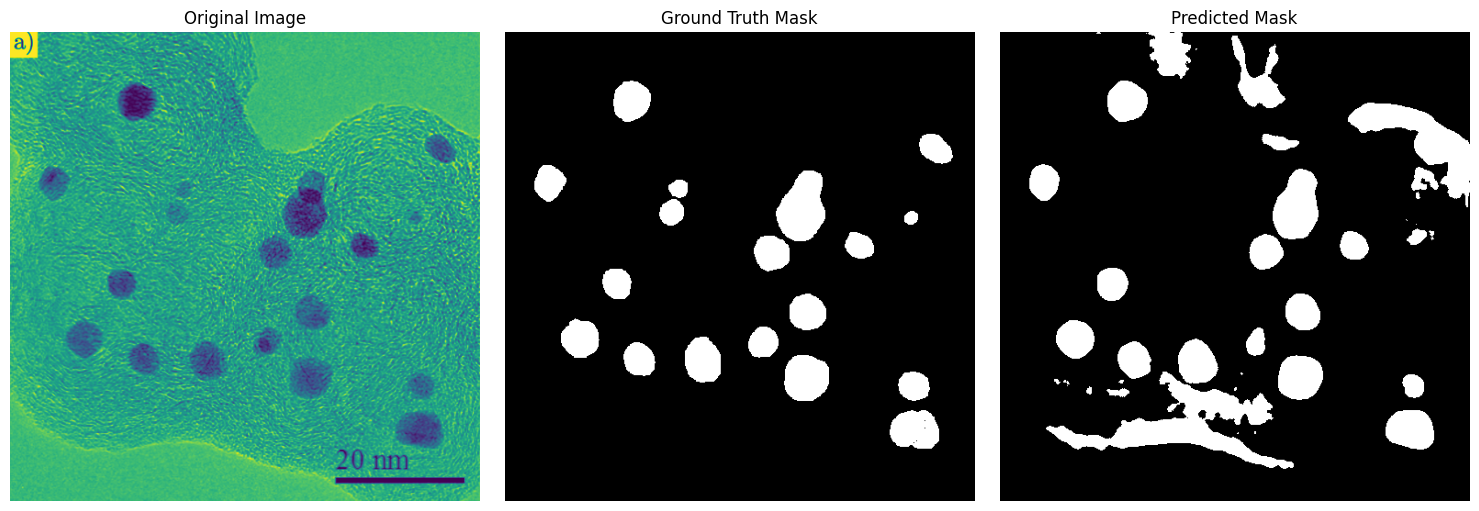

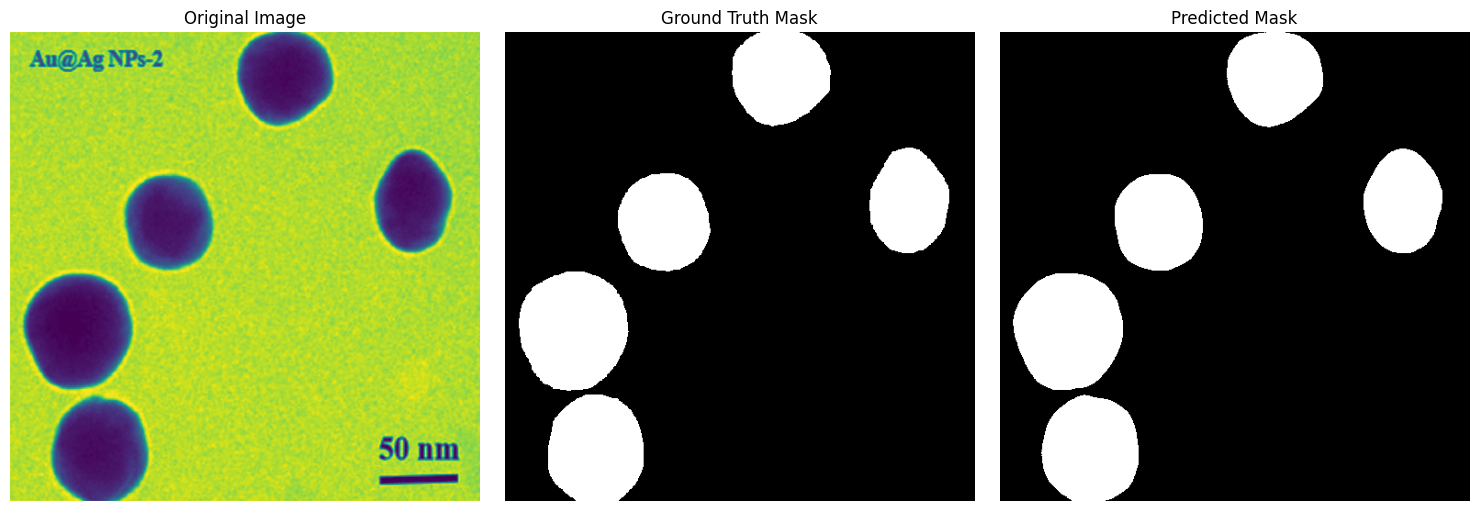

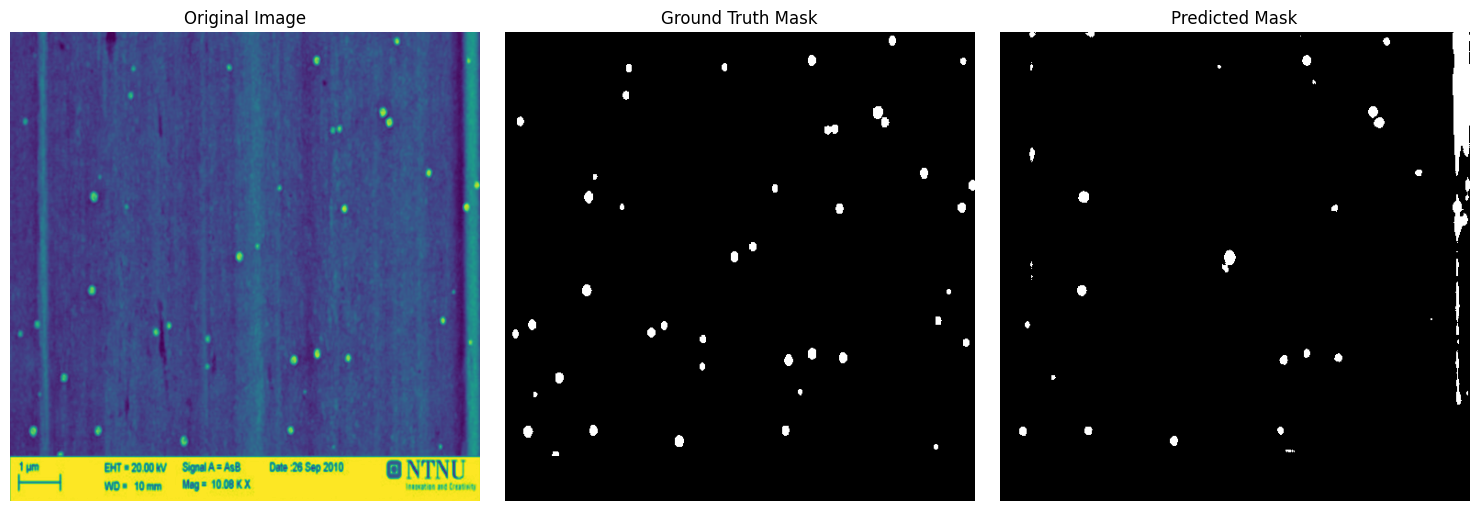

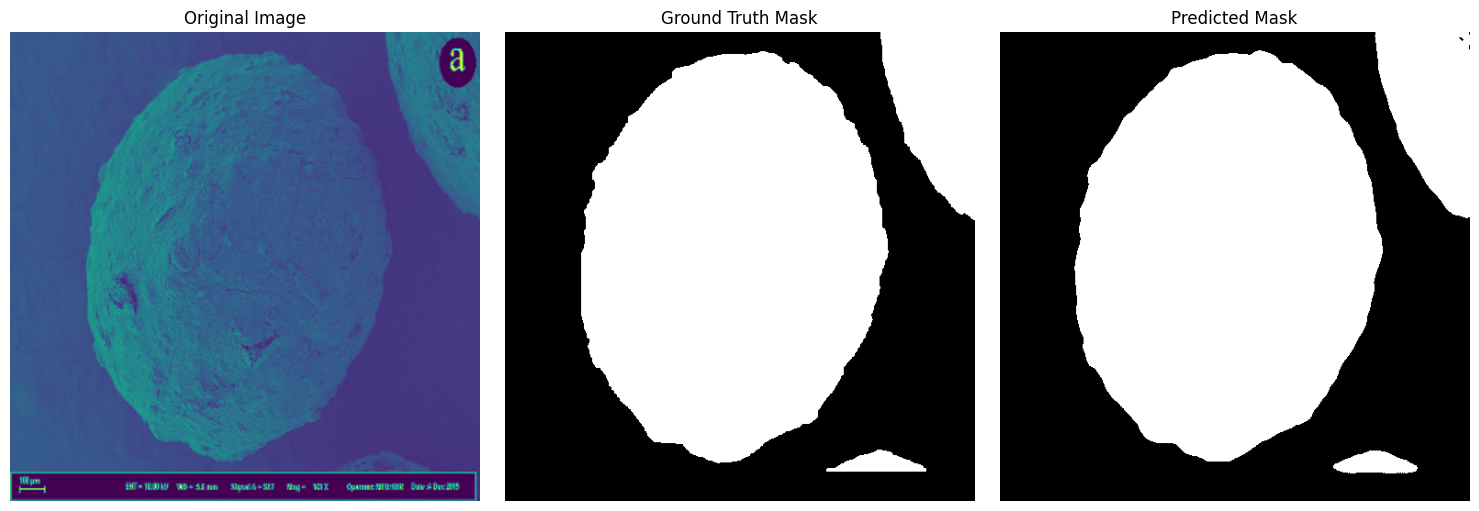

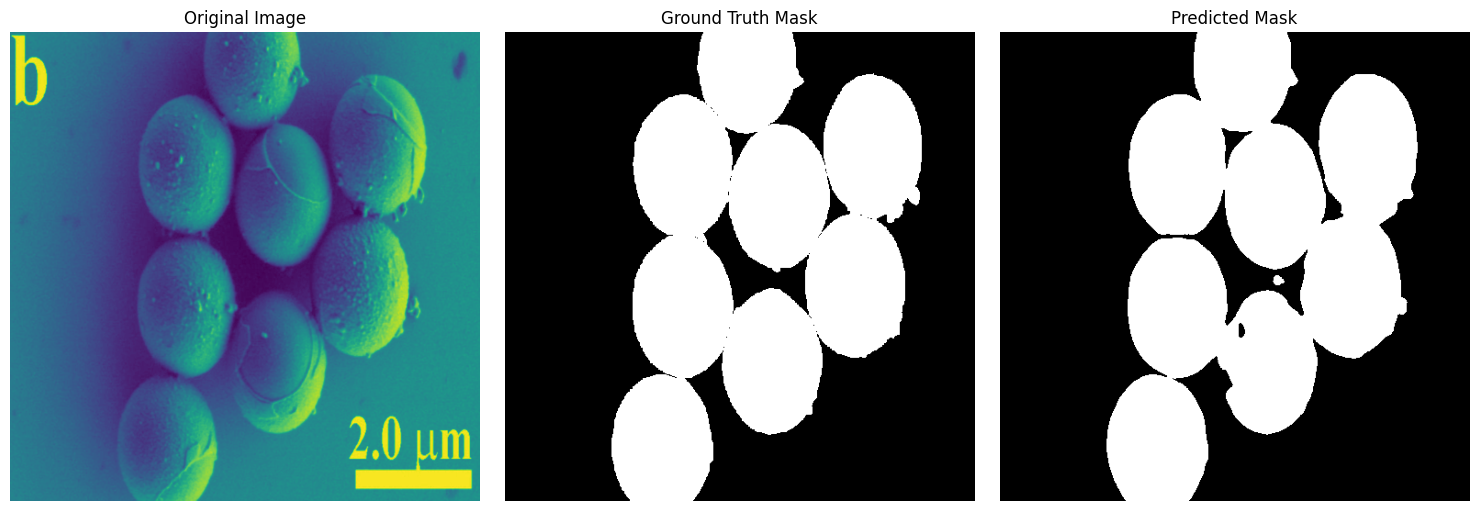

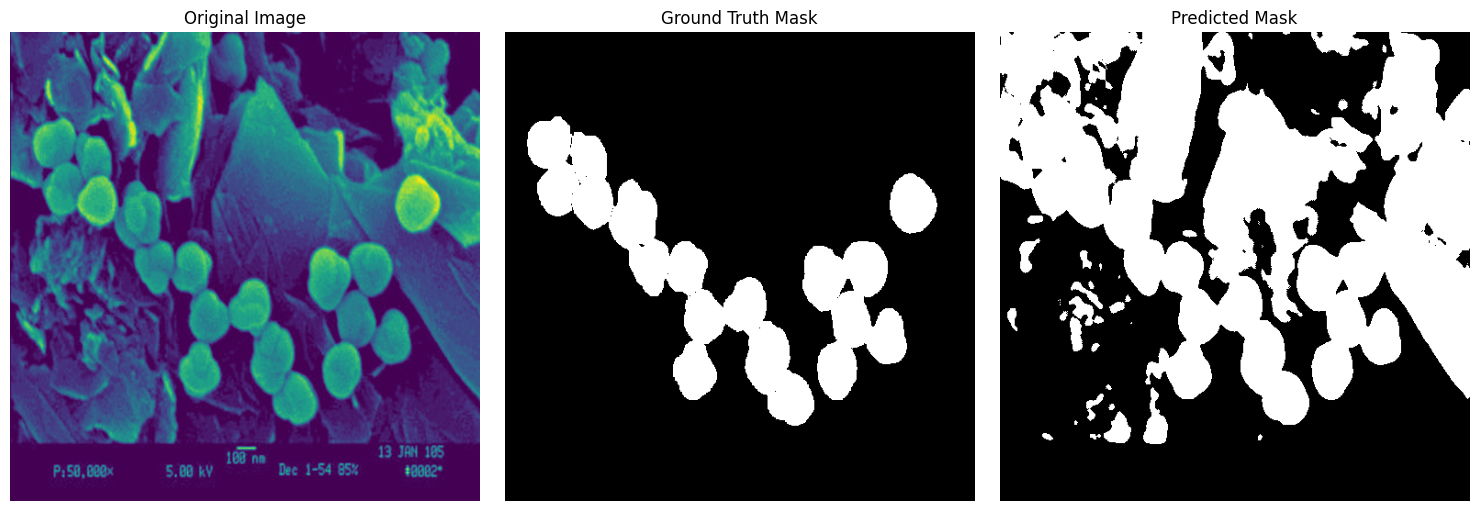

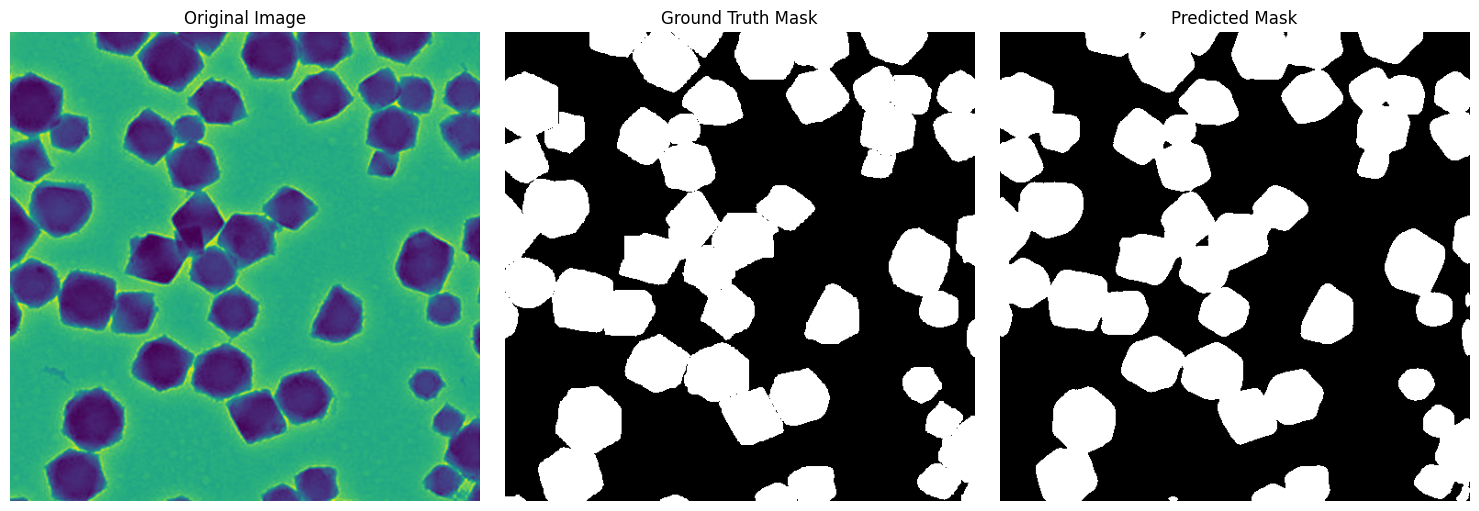

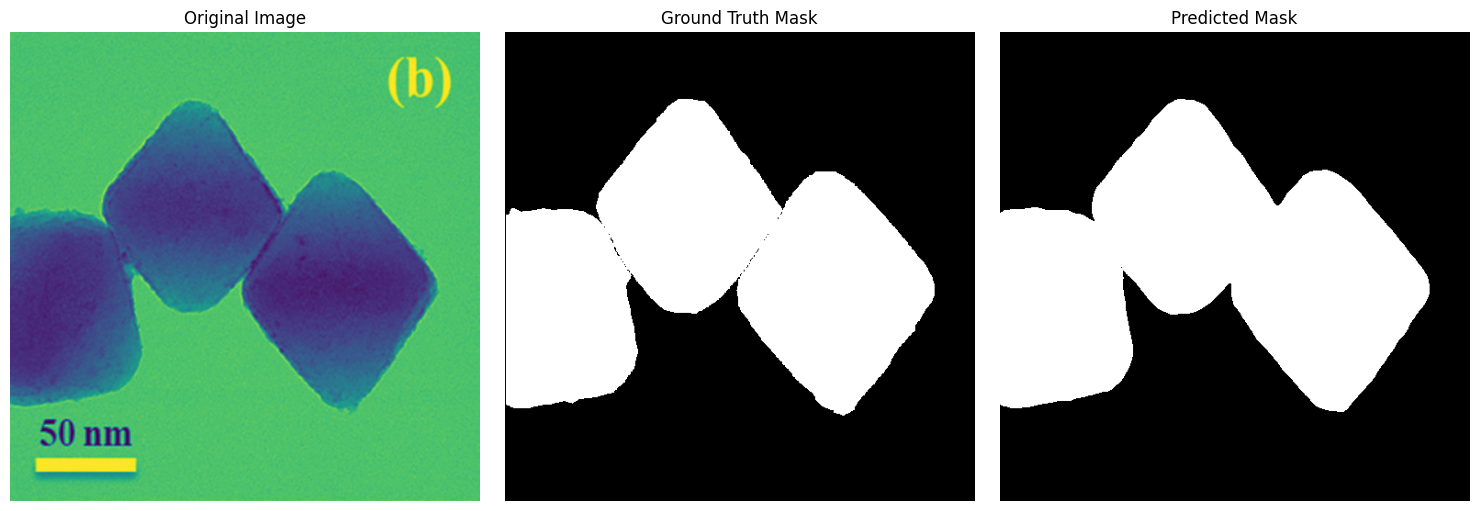

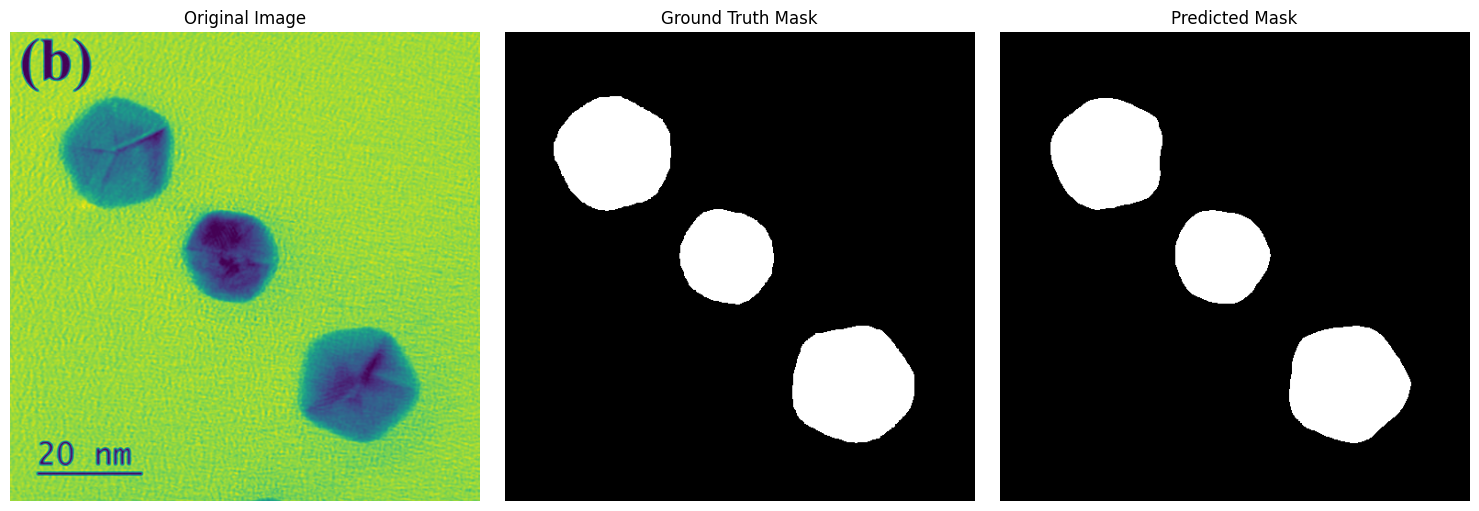

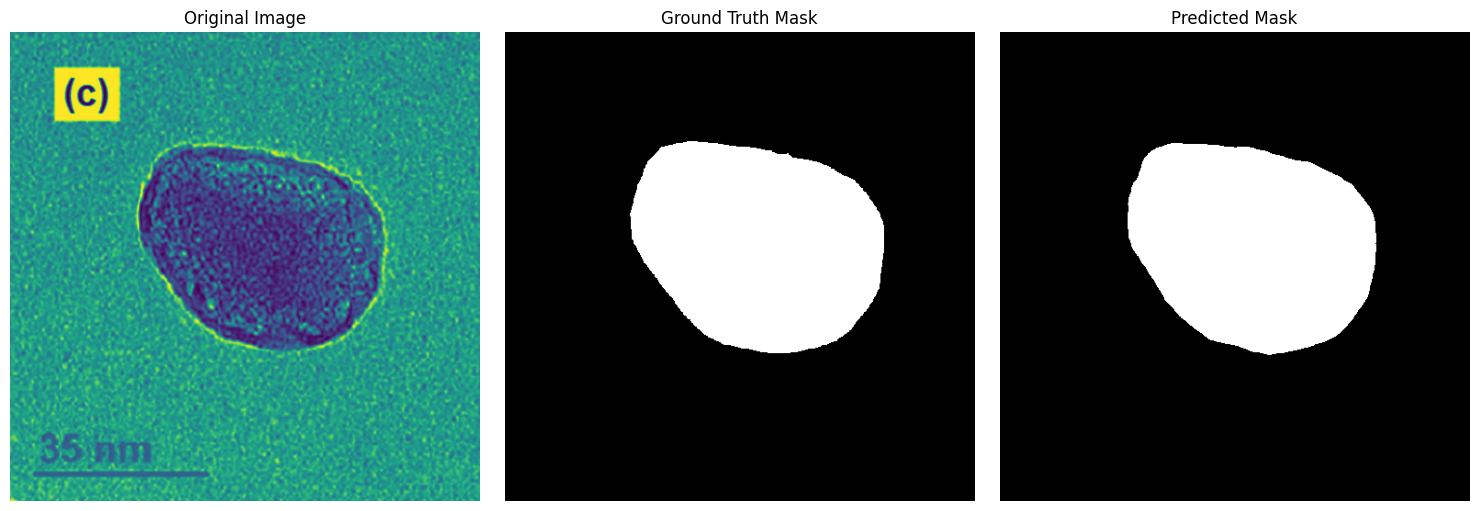

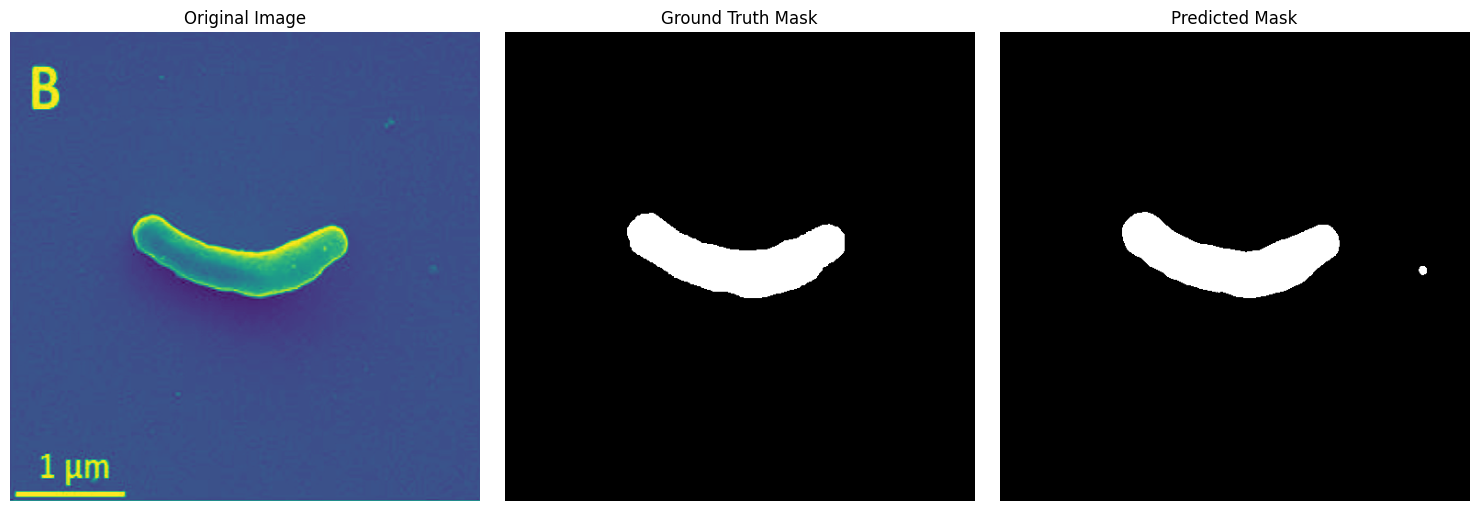

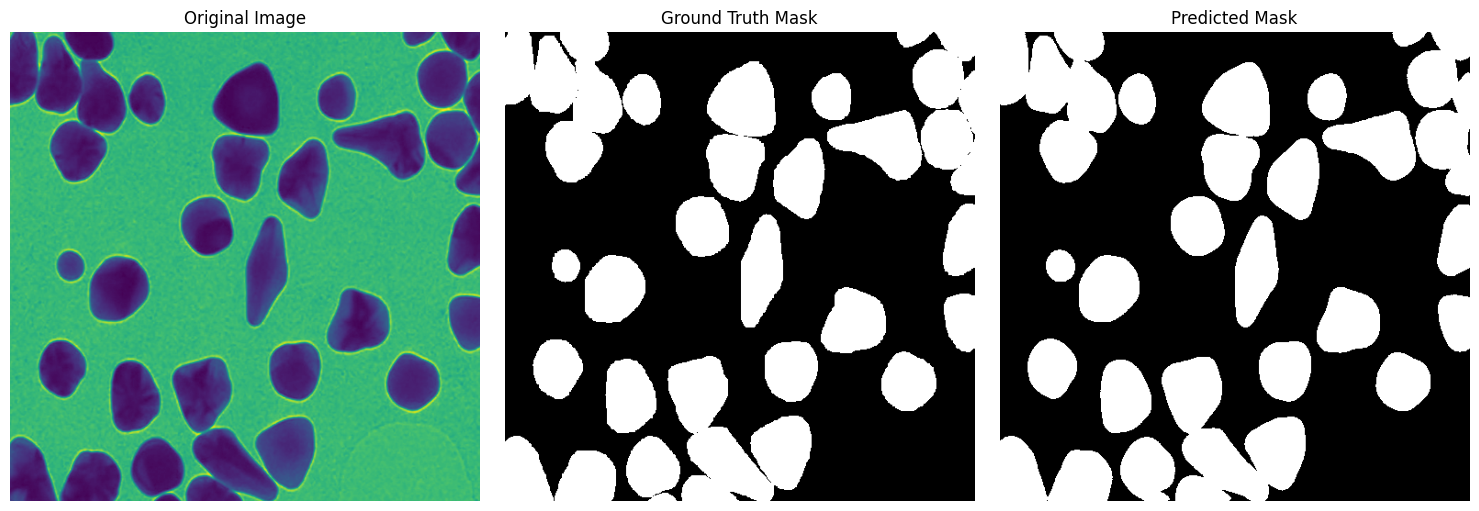

In [20]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    #img = img * std + mean  # Denormalize
    #img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [21]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy           iou  \
0       1    0.883200  0.919822   0.000000  0.000000  0.679865  8.234864e-13   
1       2    0.846920  0.886317   0.723915  0.010623  0.681969  1.285132e-02   
2       3    0.667973  0.546053   0.842929  0.953115  0.928134  8.093501e-01   
3       4    0.564943  0.586478   0.957136  0.874306  0.947226  8.414924e-01   
4       5    0.519036  0.550736   0.968890  0.875761  0.951225  8.454484e-01   
..    ...         ...       ...        ...       ...       ...           ...   
95     96    0.089447  0.162694   0.957837  0.970845  0.976985  9.319446e-01   
96     97    0.089286  0.160332   0.964428  0.964235  0.977165  9.320266e-01   
97     98    0.095468  0.162498   0.959459  0.968486  0.976811  9.313856e-01   
98     99    0.087337  0.160725   0.964327  0.963368  0.976864  9.314452e-01   
99    100    0.088310  0.162743   0.963537  0.963030  0.976498  9.301550e-01   

          f1    dice_coeff  rand_error 